In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os
import re
import random
from tensorflow.keras.models import load_model
import shutil
import gspread
from google.oauth2.service_account import Credentials

In [ ]:
IMG_SIZE = (128, 128)
TRAIN_FOLDER = ".\\train_data"
TEST_FOLDER = ".\\test_data"

OUTPUT_FOLDER = ".\\output"

train_files= ["train0.jpg", "train2.jpg", "train4.jpg", 
"train4_.jpg", "train5.jpg", "train6.jpg", "train10.jpg", "train25.jpg"]
test_files = ["test15.jpg", "test16.jpg", "test14.jpg", "test14_.jpg", "test14__.jpg", "test14___.jpg"]
final_files = ["final4.jpg", "final3.jpg"]

## Generating Data

In [3]:
def extract_background_color(img, sample_size=10):

    sample_region = img[:sample_size, :sample_size]
    avg_color = np.mean(sample_region, axis=(0, 1))
    return tuple(map(int, avg_color))

def pad_and_resize(img, target_size=(128, 128)):
    h, w = img.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    resized = cv2.resize(img, (int(w * scale), int(h * scale)))
    pad_h = target_size[0] - resized.shape[0]
    pad_w = target_size[1] - resized.shape[1]
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    
    background_color = extract_background_color(img)
    return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=background_color)

def extract_checkboxes(image_path, save_folder, for_training=False):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    file_count = len([f for f in os.listdir(save_folder) if os.path.isfile(os.path.join(save_folder, f))])

    match = re.search(r'\d+', image_path)
    uncheck_cnt = int(match.group()) if match else 0

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 200]
    boxes = sorted(boxes, key=lambda b: b[1], reverse=True)

    count = 0
    for i, (x, y, w, h) in enumerate(reversed(boxes[:32])):
        cx, cy = x + w // 2, y + h // 2
        crop = image[max(cy - 64, 0):cy + 64, max(cx - 64, 0):cx + 64]

        if crop.shape[0] != 128 or crop.shape[1] != 128:
            crop = pad_and_resize(crop)

        if for_training:
            filename = f'uncheck{uncheck_cnt}-{i+file_count+1}.png' if i >= 32 - uncheck_cnt else f'check{uncheck_cnt}-{i+file_count+1}.png'
        else:
            j = i + file_count
            if j < 10:
                num = f"00{j}"
            elif  j < 100:
                num = f"0{j}"
            else:
                num = f"{j}"
            filename = f'{num}-img.png'

        cv2.imwrite(os.path.join(save_folder, filename), crop)
        count += 1


# for file in train_files:
#     extract_checkboxes(file, TRAIN_FOLDER, for_training=True)

# for file in test_files:
#     extract_checkboxes(file, TEST_FOLDER, for_training=True)

## Augmentation

In [4]:
def extract_background_color(img, sample_size=10):
    sample_region = img[:sample_size, :sample_size]
    avg_color = np.mean(sample_region, axis=(0, 1))

    if len(img.shape) == 2: 
        return int(avg_color)
    else:  
        return tuple(map(int, avg_color))


def random_shift(img):
    dx = random.randint(-20, 45)
    dy = random.randint(-30, 15)
    h, w = img.shape[:2]
    background_color = extract_background_color(img)

    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted = cv2.warpAffine(
        img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=background_color
    )
    return shifted

def random_zoom(img, zoom_range=0.2):
    h, w = img.shape[:2]
    zoom_factor = 1 + random.uniform(-zoom_range, zoom_range)

    new_h = int(h * zoom_factor)
    new_w = int(w * zoom_factor)

    img_zoomed = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    if zoom_factor < 1:
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        background_color = extract_background_color(img)
        img_zoomed = cv2.copyMakeBorder(
            img_zoomed,
            pad_h,
            h - new_h - pad_h,
            pad_w,
            w - new_w - pad_w,
            borderType=cv2.BORDER_CONSTANT,
            value=background_color,
        )
    else:
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        img_zoomed = img_zoomed[start_h:start_h + h, start_w:start_w + w]

    return img_zoomed

def random_brightness(img, brightness_range=(0.7, 1.3)):
    factor = random.uniform(*brightness_range)
    bright_img = img.astype(np.float32) * factor
    bright_img = np.clip(bright_img, 0, 255).astype(np.uint8)
    return bright_img

def augment_images(path, aug_cnt):
    for filename in os.listdir(path):
        if "uncheck" in filename and not "aug" in filename:
            img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
            
            for i in range(aug_cnt):
                output_path = os.path.join(path, f'{filename}-aug{i}.png')
                cv2.imwrite(output_path, random_shift(random_zoom(random_brightness(img))))

# augment_images(TRAIN_FOLDER, 5)

## Loading Data

In [5]:
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # print(filename)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)  
            img = img / 255.0  
            images.append(img)

            if "uncheck" in filename.lower():  
                labels.append(0) 
            else:
                labels.append(1)  
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

In [37]:
train_images = []
train_labels = []
train_images, train_labels = load_data(TRAIN_FOLDER)

print(train_images.shape)

(902, 128, 128)


In [38]:
test_images = []
test_labels = []
test_images, test_labels = load_data(TEST_FOLDER)

print(test_images.shape)

(181, 128, 128)


In [39]:
train_images = train_images.reshape((-1, 128, 128, 1))
test_images = test_images.reshape((-1, 128, 128, 1))

In [40]:
indices = np.arange(len(train_images))
np.random.shuffle(indices)

train_images = train_images[indices]
train_labels = train_labels[indices]

## Convolutional Neural Network

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.125),
    Dense(1, activation='sigmoid')
])

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
29/29 [==============================] - 3s 93ms/step - loss: 0.8364 - accuracy: 0.5466
Epoch 2/10
29/29 [==============================] - 3s 86ms/step - loss: 0.5920 - accuracy: 0.6885
Epoch 3/10
29/29 [==============================] - 3s 95ms/step - loss: 0.5316 - accuracy: 0.7295
Epoch 4/10
29/29 [==============================] - 3s 105ms/step - loss: 0.4766 - accuracy: 0.7627
Epoch 5/10
29/29 [==============================] - 3s 93ms/step - loss: 0.4233 - accuracy: 0.7894
Epoch 6/10
29/29 [==============================] - 3s 97ms/step - loss: 0.3762 - accuracy: 0.8215
Epoch 7/10
29/29 [==============================] - 3s 94ms/step - loss: 0.4247 - accuracy: 0.8004
Epoch 8/10
29/29 [==============================] - 3s 99ms/step - loss: 0.3197 - accuracy: 0.8481
Epoch 9/10
29/29 [==============================] - 3s 91ms/step - loss: 0.3107 - accuracy: 0.8625
Epoch 10/10
29/29 [==============================] - 3s 91ms/step - loss: 0.2928 - accuracy: 0.8681


In [ ]:
# model.save('the_last_model.h5')

c:\Users\acer\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
model = load_model('the_last_model.h5')

_, test_accuracy = model.evaluate(test_images,  test_labels, verbose = 2)

print('accuracy:', test_accuracy)

predictions = model.predict(test_images)

correct_cnt = 0
for i in range(len(test_images)):
    predicted_class = 1 if predictions[i] > 0.5 else 0  
    
    if predicted_class == test_labels[i]:
        correct_cnt += 1
        # print(f"+ Image {i + 1} - Predicted Class: {predicted_class}, Actual Class: {test_labels[i]}, Prediction Val: {predictions[i]}")
    else:
        print(f"- Image {i + 1} - Predicted Class: {predicted_class}, Actual Class: {test_labels[i]}, Prediction Val: {predictions[i]}")

acc = correct_cnt / len(test_images)
print(f"Corrects: {correct_cnt}")
print(f"Wrongs: {len(test_images) - correct_cnt}")


6/6 - 0s - loss: 0.2636 - accuracy: 0.9503 - 237ms/epoch - 39ms/step
accuracy: 0.950276255607605
6/6 [==============================] - 0s 27ms/step
- Image 5 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.2981258]
- Image 7 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.3506056]
- Image 10 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.04029689]
- Image 27 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.3779477]
- Image 38 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.2762597]
- Image 46 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.39337796]
- Image 60 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.35442555]
- Image 62 - Predicted Class: 0, Actual Class: 1, Prediction Val: [0.41669938]
- Image 171 - Predicted Class: 1, Actual Class: 0, Prediction Val: [0.8600309]
Corrects: 172
Wrongs: 9


In [77]:
# model.save("final_model2.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 127008)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                2032144   
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                      

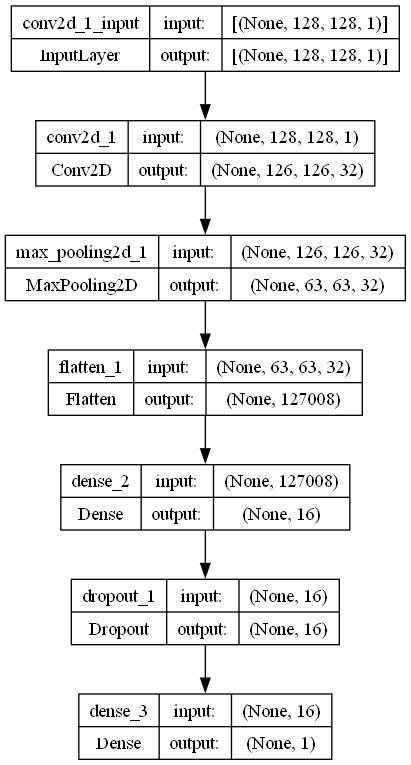

In [ ]:
plot_model(model, to_file="the_last_model_architecture.png", show_shapes=True, show_layer_names=True)

## Using The Model

In [80]:
def load_data_useage(path):
    images = []
    image_names = []
    for filename in sorted(os.listdir(path)):
        image_names.append(filename)
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0
            images.append(img)
    return np.array(images, dtype=np.float32), image_names


In [86]:
if os.path.exists(OUTPUT_FOLDER):
        shutil.rmtree(OUTPUT_FOLDER)

for filename in final_files:
    extract_checkboxes(filename, OUTPUT_FOLDER)

In [87]:
output_images, image_names = load_data_useage(OUTPUT_FOLDER)
output_images = output_images.reshape((-1, 128, 128, 1))

In [88]:
model = load_model('the_last_model.h5')

predictions = model.predict(output_images)

model_output = []
for i in range(len(output_images)):
    predicted_class = 1 if predictions[i] > 0.5 else 0  
    model_output.append(predicted_class)
    

for i, output in enumerate(model_output):
    print(f"{image_names[i]} {output}")
print(len(model_output))

checked_folder = 'output-checkfolder'
unchecked_folder = 'output-uncheckfolder'

for folder in [checked_folder, unchecked_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

os.makedirs(checked_folder, exist_ok=True)
os.makedirs(unchecked_folder, exist_ok=True)

for i, output in enumerate(model_output):
    src = OUTPUT_FOLDER + "\\" + image_names[i]
    if output == 1:
        dst = os.path.join(checked_folder, os.path.basename(src))
    else:
        dst = os.path.join(unchecked_folder, os.path.basename(src))
    
    shutil.copy(src, dst)    

2/2 [==============================] - 0s 36ms/step
000-img.png 1
001-img.png 0
002-img.png 1
003-img.png 1
004-img.png 1
005-img.png 1
006-img.png 1
007-img.png 1
008-img.png 0
009-img.png 1
010-img.png 0
011-img.png 1
012-img.png 0
013-img.png 1
014-img.png 1
015-img.png 0
016-img.png 0
017-img.png 0
018-img.png 0
019-img.png 0
020-img.png 1
021-img.png 1
022-img.png 0
023-img.png 0
024-img.png 0
025-img.png 0
026-img.png 1
027-img.png 1
028-img.png 1
029-img.png 0
030-img.png 1
031-img.png 0
032-img.png 1
033-img.png 1
034-img.png 1
035-img.png 1
036-img.png 1
037-img.png 1
038-img.png 1
039-img.png 0
040-img.png 0
041-img.png 0
042-img.png 0
043-img.png 1
044-img.png 0
045-img.png 1
046-img.png 1
047-img.png 1
048-img.png 0
049-img.png 0
050-img.png 0
051-img.png 0
052-img.png 1
053-img.png 1
054-img.png 0
055-img.png 0
056-img.png 0
057-img.png 0
058-img.png 0
059-img.png 1
060-img.png 1
061-img.png 1
062-img.png 1
063-img.png 1
64


In [89]:
SERVICE_ACCOUNT_FILE = 'bot_cred.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

creds = Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE,
    scopes=SCOPES
)

client = gspread.authorize(creds)
sheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1M-Neh3nGHSXbEVnhWBz5aAZYTcTsWpbCQ3SmS0fH-XU")
worksheet = sheet.worksheet("Sheet1")

data = worksheet.get_all_values()
print(data)

[['Student ID', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35'], ['ID1', 'TRUE', 'TRUE', 'TRUE', 'FALSE', 'TRUE', 'FALSE', 'TRUE', 'FALSE', 'TRUE', 'TRUE', 'TRUE', 'TRUE', 'FALSE', 'TRUE', 'TRUE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE'], ['ID2', 'TRUE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'TRUE', 'FALSE', 'FALSE', 'TRUE', 'FALSE', 'TRUE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE', 'FALSE'], ['ID3', 'TRUE', 'TRUE', 'FALSE', 'FALSE', 'TRUE', 'FALSE', 'TRUE', 'FALSE', 'FALSE', 'TRUE', 'FALSE', 'TRUE', 'FAL

In [90]:
mapper = {1: True, 0: False}
start_cell = "W2"

attendance = []
for prediction in model_output:
    attendance.append([mapper[prediction]])

worksheet.update(start_cell, attendance)  

C:\Users\acer\AppData\Local\Temp\ipykernel_5764\1948848613.py:8: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(start_cell, attendance)


{'spreadsheetId': '1M-Neh3nGHSXbEVnhWBz5aAZYTcTsWpbCQ3SmS0fH-XU',
 'updatedRange': 'Sheet1!W2:W65',
 'updatedRows': 64,
 'updatedColumns': 1,
 'updatedCells': 64}